<a href="https://colab.research.google.com/github/0537ch/loganalyser/blob/main/LogAnalyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain_community
!pip install replicate

In [ ]:
# Import necessary libraries
from langchain_community.llms import Replicate
from google.colab import userdata
import os
import pandas as pd
import urllib.parse  # ✅ Added for URL decoding

try:
    replicate_api_token = userdata.get('REPLICATE_API_TOKEN')
    os.environ["REPLICATE_API_TOKEN"] = replicate_api_token
    print("✅ Replicate API token loaded successfully.")
except Exception as e:
    print(f"❌ Could not load API token. Please follow setup instructions. Error: {e}")

# --- Initialize the LLM Model Object ---
llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
    model_kwargs={"max_new_tokens": 100}
)
print("✅ LLM Model initialized.")

# --- Load and Prepare Data ---
file_name = 'sample_data/csic_database.csv'
try:
    print(f"\nAttempting to load '{file_name}'...")
    df = pd.read_csv(file_name)
    df['log'] = df['Method'].astype(str) + " " + df['URL'].astype(str) + " " + df['content'].fillna('').astype(str)
    label_col_name = df.columns[0]
    df = df.rename(columns={label_col_name: 'label'})
    df['label'] = df['label'].apply(lambda x: 'Benign' if str(x).strip().lower() == 'normal' else 'Malicious')
    df_clean = df[['log', 'label']].sample(frac=1).reset_index(drop=True)
    print("✅ Data preparation successful!")
except Exception as e:
    print(f"❌ Error during data loading: {e}")

# --- Define the analysis function ---
def analyze_log_tuned(log_entry):
    """
    Sends a log entry to the LLM with few-shot examples to improve accuracy.
    """
    # ✅ Decode URL to reveal encoded attacks
    decoded_log = urllib.parse.unquote_plus(log_entry)

    prompt = f"""
            You are a cybersecurity analyst. Your task is to classify HTTP request logs as either 'Benign' or 'Malicious'. Give a short explanation (1 sentence max).

            Use this format:
            Classification: [Benign or Malicious] | Reasoning: [short reasoning here]

            Examples:
            ---
            Request: POST http://localhost:8080/tienda1/publico/registro.jsp HTTP/1.1
            Body: modo=registro&login=user&password=1234&email=user@example.com
            Classification: Benign | Reasoning: Standard user registration with typical parameters.

            Request: POST http://localhost:8080/tienda1/publico/pagar.jsp HTTP/1.1
            Body: modo=insertar&precio=2500&B1=Confirmar
            Classification: Benign | Reasoning: A normal transaction with expected parameters.

            Request: GET /etc/passwd HTTP/1.1
            Classification: Malicious | Reasoning: Attempt to access sensitive system file.

            Request: GET /tienda1/publico/entrar.jsp?username=' OR '1'='1 HTTP/1.1
            Classification: Malicious | Reasoning: SQL injection attempt in query string.

            Be cautious of encoded or obfuscated payloads, suspicious system paths, and common attack patterns.

            Now classify this request:

            Request:
        {decoded_log}
            """

    try:
        generated_response = llm.invoke(prompt)
        parts = generated_response.split('|')
        classification = parts[0].replace('Classification:', '').strip()
        reasoning = parts[1].replace('Reasoning:', '').strip()
        return classification, reasoning
    except Exception as e:
        return "Error", str(e)

# --- Test the function with one log entry ---
if 'df_clean' in locals():
    test_log = df_clean['log'].iloc[0]
    true_label = df_clean['label'].iloc[0]
    print(f"🔍 Testing with reconstructed log:\n{test_log}")
    print(f"🧾 Actual Label (Ground Truth): {true_label}\n")

    classification, reasoning = analyze_log_tuned(test_log)
    print(f"🤖 AI Classification: {classification}")
    print(f"📌 AI Reasoning: {reasoning}")
else:
    print("❌ Please run the setup block (Block 1) first to load the data.")


✅ Replicate API token loaded successfully.
✅ LLM Model initialized.

Attempting to load 'sample_data/csic_database.csv'...
✅ Data preparation successful!
🔍 Testing with reconstructed log:
POST http://localhost:8080/tienda1/publico/entrar.jsp HTTP/1.1 errorMsg=Credenciales+incorrectas
🧾 Actual Label (Ground Truth): Benign

🤖 AI Classification: Benign
📌 AI Reasoning: This is a standard login attempt with an expected error message indicating incorrect credentials.


[1]
Log: GET http://localhost:8080/tienda1/miembros/imagenes/castro.jpg HTTP/1.1 
True: Benign | Predicted: Benign
---
[2]
Log: GET http://localhost:8080/tienda1/miembros/editar.jsp/6909030637832563290.jsp.java HTTP/1.1 
True: Malicious | Predicted: Malicious
---
[3]
Log: POST http://localhost:8080/tienda1/publico/vaciar.jsp HTTP/1.1 B2=Vaciar+carrito
True: Benign | Predicted: Malicious
---
[4]
Log: GET http://localhost:8080/tienda1/publico/vaciar.jsp?B2=Vaciar+carrito HTTP/1.1 
True: Benign | Predicted: Benign
---
[5]
Log: GET http://localhost:8080/tienda1/publico/vaciar.jsp?B2=Vaciar+carrito HTTP/1.1 
True: Benign | Predicted: Benign
---
[6]
Log: GET http://localhost:8080/tienda1/imagenes/1.gif/asf-logo-wide.gif/ HTTP/1.1 
True: Malicious | Predicted: Benign
---
[7]
Log: GET http://localhost:8080/tienda1/index.jsp HTTP/1.1 
True: Benign | Predicted: Benign
---
[8]
Log: POST http://localhost:8080/tienda1/publico/autenticar.jsp HTTP/1.1 modo=entrar&login=kavid&pwd=Sa5Na&remember=on&B1=

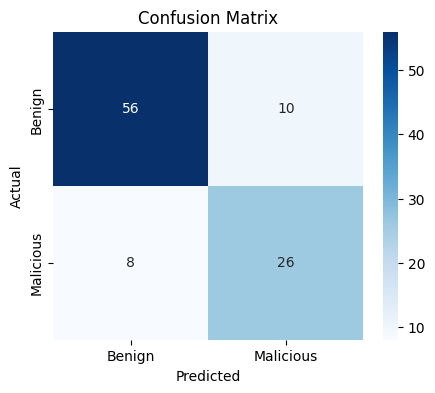

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Evaluation function with CSV saving ---
def evaluate_llm_on_logs(df, n_samples=100, output_file="llm_predictions.csv"):
    sample_df = df.sample(n=n_samples).reset_index(drop=True)
    y_true = []
    y_pred = []
    results = []

    for i, row in sample_df.iterrows():
        log_entry = row['log']
        true_label = row['label']
        pred_label, _ = analyze_log_tuned(log_entry)

        print(f"[{i+1}]")
        print(f"Log: {log_entry}")
        print(f"True: {true_label} | Predicted: {pred_label}")
        print("---")

        y_true.append(true_label)
        y_pred.append(pred_label)
        results.append({
            "log": log_entry,
            "true_label": true_label,
            "predicted_label": pred_label,
            "correct": "Yes" if true_label == pred_label else "No"
        })

    # Save results to CSV
    result_df = pd.DataFrame(results)
    result_df.to_csv(output_file, index=False)
    print(f"✅ Results saved to '{output_file}'")

    # --- Report ---
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, digits=3))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_true, y_pred, labels=["Benign", "Malicious"])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Benign", "Malicious"], yticklabels=["Benign", "Malicious"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# --- Run Evaluation ---
if 'df_clean' in locals():
    evaluate_llm_on_logs(df_clean, n_samples=100, output_file="llm_predictions.csv")
else:
    print("❌ Dataset not loaded. Please run the data loading block first.")
